# implementing llama3 from scratch

it is a *playground* type notebook in which i will upload write some notes and there will be experiments and i upload the full code in a different python script

in this i will use llama3.2-1b as it is small in size and more memory/perfomance efficient for me

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt
import os 

In [2]:
tokenizer_path = os.path.expanduser("~/Codes/Llama3.2-1B/tokenizer.model")
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
# Load the BPE merge ranks from the tokenizer model file 
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)

# Create a new tokenizer encoding with:
# - Name based on tokenizer model filename
# - Regex pattern for tokenization that handles:
#   - Contractions ('s, 't, etc)
#   - Words (\p{L}+)
#   - Numbers (1-3 digits)
#   - Special characters/punctuation
#   - Newlines and whitespace
# - Merge ranks loaded from model file
# - Special tokens dictionary mapping tokens to IDs starting after merge ranks
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)




In [3]:
tokenizer.encode("hello worlddddddd")

[15339, 1917, 65200, 634]

In [4]:
tokenizer.decode([15339, 1917, 65200, 634])

'hello worlddddddd'

In [5]:
model = torch.load(os.path.expanduser("~/Codes/Llama3.2-1B/consolidated.00.pth"),map_location=torch.device('mps'))
print(json.dumps(list(model.keys())[:100], indent=4))

/var/folders/_l/nhxzf35d68n8q7gbvlp97d0w0000gn/T/ipykernel_7219/3733364310.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.expanduser("~/Codes

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight",
    "layers.2.attention.wk.weight",
    "layers.2.attention.wv.weight",
    "layers.2.attention.wo.weight",
    "layers.2.feed_forward.w1.weight",
    "layers.2.feed_forward.w3.weight",
    "layers.2.feed_forward.w2.weight",
    "layers.2.attention_norm.weight",
    "lay

In [6]:
len(model)

147

In [7]:
with open(os.path.expanduser("~/Codes/Llama3.2-1B/params.json"), "r") as f:
    config = json.load(f)
config

{'dim': 2048,
 'ffn_dim_multiplier': 1.5,
 'multiple_of': 256,
 'n_heads': 32,
 'n_kv_heads': 8,
 'n_layers': 16,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0,
 'use_scaled_rope': True,
 'vocab_size': 128256}

### about config

- this model has *16* transformer layers
- and each multi-head attention block has *32* heads

In [8]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

In [9]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


In [10]:
print(len(prompt_split_as_tokens))

17


In [11]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 2048])

basically `17`, `(1, 2048)` staced on each other

> now we have to normalize the embedding using rms normalization (we will use `norm_eps` from config)

### about RMSnorm

- it is root mean squared layer normalization which is a part of pre normalization used in llama 3
- it is basically an extenstion to the layernorm

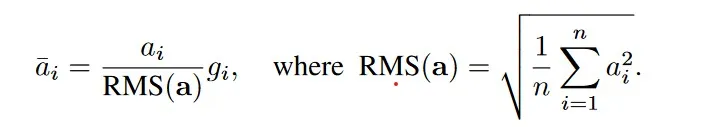

Intuitively, RMSNorm simplifies LayerNorm by totally removing the mean statistic in LayerNorm.


In [12]:
def rms_norm(tensor, norm_weights):
      return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

---

## first layer of transformer

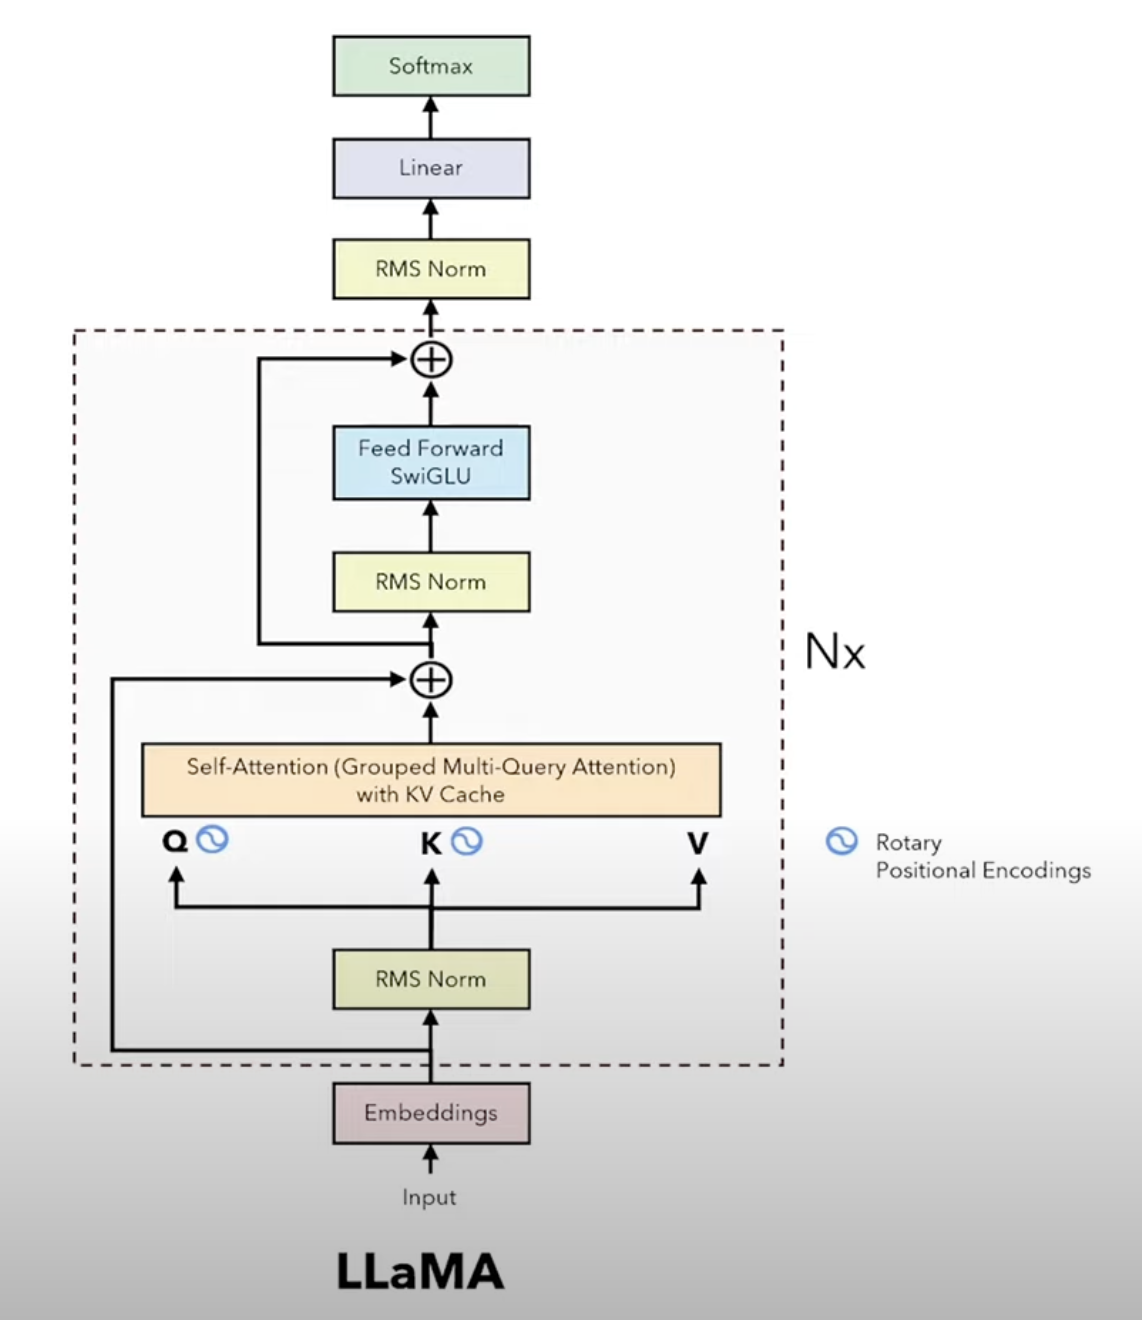

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [14]:
# normalizing the embedding input by layer norm
# here we are accessubg
token_embeddings_unnormalized = token_embeddings_unnormalized.to(device)
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])

print("shape is:",token_embeddings.shape)
token_embeddings[:50]

shape is: torch.Size([17, 2048])


tensor([[ 0.0232,  0.0310, -0.1377,  ..., -0.0204,  0.0092,  0.0056],
        [-0.0791, -0.2773, -0.2871,  ..., -0.1562,  0.0688, -0.1562],
        [-0.0481,  0.3281,  0.5078,  ...,  0.3613,  0.1904,  0.0723],
        ...,
        [ 0.2949,  0.0864,  0.6016,  ...,  0.0850,  0.1670,  0.0598],
        [ 0.0859,  0.1846,  0.3672,  ..., -0.1196,  0.1094,  0.0781],
        [ 0.0352, -0.1963,  0.4238,  ..., -0.1602, -0.1719, -0.2334]],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

---

#### attention implemented

as it is llama architecture so it use grouped-query attention (GQA) instead of simple self attention so the key and value are also grouped unlike normal attention 

In [15]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([2048, 2048]) torch.Size([512, 2048]) torch.Size([512, 2048]) torch.Size([2048, 2048])


In [74]:
# unwrapping query
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
print(head_dim)
q_layer0.shape

64


torch.Size([32, 64, 2048])

In [18]:

d_model = dim
head_dim = d_model // n_heads 
print(f"Q dimension: {n_heads * head_dim}")      
print(f"K/V dimension: {n_kv_heads * head_dim}") 
print(f"head dimension: {head_dim}")
print(d_model//n_heads)
print(d_model//n_kv_heads)
del d_model 


Q dimension: 2048
K/V dimension: 512
head dimension: 64
64
256


In [19]:
print(len(q_layer0))
print(q_layer0.shape)
print(len(q_layer0[0]))
print(len(q_layer0[0][0]))

32
torch.Size([32, 64, 2048])
64
2048


In [20]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape


torch.Size([64, 2048])

##### multiply it by embedding to get the query vector

In [21]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 64])

#### rope 

query and key vectors use RoPE to encode the rotational information of the position of the data 

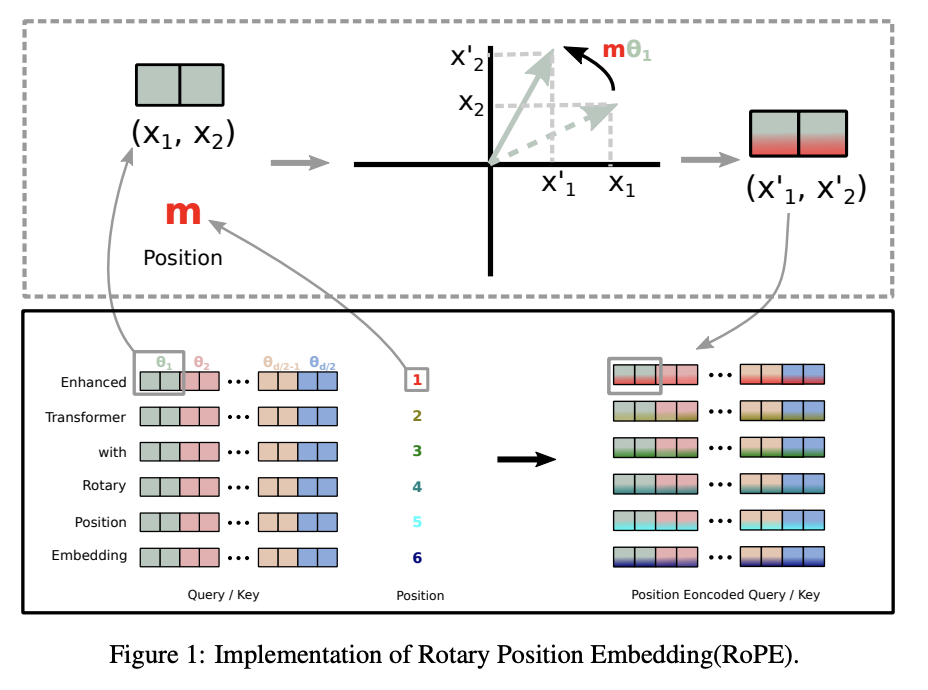

In [44]:
#If you have a vector [a, b], it's treated as the complex number a + bi.

q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape
q_per_token_split_into_pairs.to(device)

tensor([[[-0.1187, -0.5508],
         [-0.2578, -0.6211],
         [ 0.4648, -0.2812],
         ...,
         [-0.0933, -0.2578],
         [-0.0295,  0.4844],
         [-0.3867,  0.2793]],

        [[ 0.3242, -0.2734],
         [ 0.9883, -0.6523],
         [ 1.9297,  1.3438],
         ...,
         [-1.1719, -1.4531],
         [ 1.4453,  0.6016],
         [-2.3438,  0.0410]],

        [[ 0.9062, -0.0977],
         [ 2.0156, -1.2422],
         [ 1.8438,  1.3750],
         ...,
         [-0.8711, -1.4297],
         [ 0.9922,  1.1797],
         [-2.2344,  0.8789]],

        ...,

        [[ 1.0312, -0.1484],
         [ 2.3438, -1.1250],
         [ 2.2969,  1.2266],
         ...,
         [-1.0469, -1.2266],
         [ 1.1641,  0.7891],
         [-2.4375,  1.2031]],

        [[ 0.9180, -0.0437],
         [ 3.4375, -0.9727],
         [ 3.1875,  1.3359],
         ...,
         [-2.4219, -1.5312],
         [ 1.4922,  1.5234],
         [-4.0000,  1.4453]],

        [[ 0.8477, -0.2090],
       

In [45]:
zero_to_one_split_into_32_parts = torch.tensor(range(32))/32 # 32 cause we are using llama3.2 1b
# zero_to_one_split_into_64_parts
zero_to_one_split_into_32_parts.to(device)

tensor([0.0000, 0.0312, 0.0625, 0.0938, 0.1250, 0.1562, 0.1875, 0.2188, 0.2500,
        0.2812, 0.3125, 0.3438, 0.3750, 0.4062, 0.4375, 0.4688, 0.5000, 0.5312,
        0.5625, 0.5938, 0.6250, 0.6562, 0.6875, 0.7188, 0.7500, 0.7812, 0.8125,
        0.8438, 0.8750, 0.9062, 0.9375, 0.9688], device='mps:0')

In [46]:
# This implements the frequency formula(GIVEN AS THETHA_D)
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_32_parts)
freqs

tensor([1.0000e+00, 6.6360e-01, 4.4037e-01, 2.9223e-01, 1.9392e-01, 1.2869e-01,
        8.5397e-02, 5.6670e-02, 3.7606e-02, 2.4955e-02, 1.6560e-02, 1.0990e-02,
        7.2927e-03, 4.8394e-03, 3.2114e-03, 2.1311e-03, 1.4142e-03, 9.3847e-04,
        6.2277e-04, 4.1327e-04, 2.7425e-04, 1.8199e-04, 1.2077e-04, 8.0143e-05,
        5.3183e-05, 3.5292e-05, 2.3420e-05, 1.5542e-05, 1.0313e-05, 6.8440e-06,
        4.5417e-06, 3.0139e-06])

The math behind RoPE is based on complex number rotations. For each position `m` and dimension pair `d`, RoPE applies a rotation of:

$$R_{d}(m) = e^{im\theta_d}$$

where:
- `m` is the position in the sequence
- `θ_d` is the frequency for dimension `d`
- The rotation is represented as a complex number on the unit circle

The key insight of RoPE is that when you apply these rotations to your query and key vectors, the dot product between a query and key becomes position-aware. The relative position between tokens is encoded in the angle between their rotated vectors.

The formula for the rotation frequency at dimension `d` is:

$$\theta_d = \frac{1}{base^{2d/dim}}$$

where:
- `base` is `rope_theta` (typically 10000)
- `dim` is the embedding dimension
- `d` ranges from 0 to dim/2 (since we work with pairs)

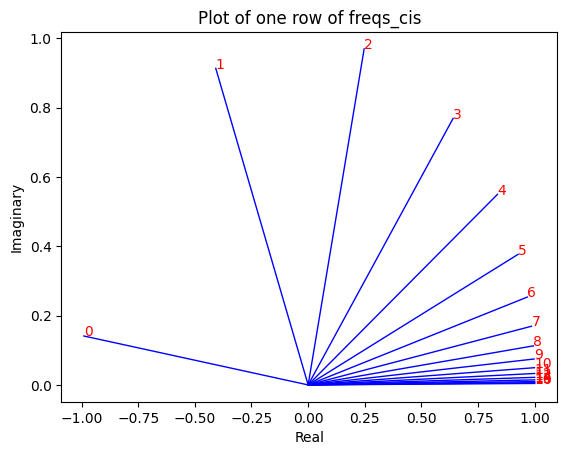

In [ ]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis.to(device).to(device).to(device).to(device).to(device)')
plt.show()

In [48]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape
q_per_token_as_complex_numbers = q_per_token_as_complex_numbers.to(device)

In [50]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis.to(device)
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 32])

In [54]:
# after the rotated vector is obtained converting it back into real numbers
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
print("the shape is:",q_per_token_split_into_pairs_rotated.shape)
q_per_token_split_into_pairs_rotated[:1]

the shape is: torch.Size([17, 32, 2])


tensor([[[-0.1187, -0.5508],
         [-0.2578, -0.6211],
         [ 0.4648, -0.2812],
         [-0.1426,  0.1089],
         [ 0.0508,  0.0297],
         [-0.0432,  0.0483],
         [-0.0287, -0.6328],
         [ 0.0942,  0.3945],
         [ 0.1387, -0.2988],
         [-0.6367, -0.0630],
         [ 0.1709,  0.5586],
         [ 0.2695, -0.3926],
         [-0.4668,  0.1895],
         [-0.1084, -0.5703],
         [-0.3262,  0.3027],
         [-0.5273,  0.0420],
         [ 0.3125,  0.0176],
         [ 0.1768, -0.3477],
         [ 0.1309,  0.0173],
         [-0.0874, -0.4004],
         [ 0.0206, -0.4961],
         [ 0.2100, -0.5938],
         [ 0.3145,  0.2637],
         [ 0.2559,  0.1533],
         [ 0.2363, -0.2852],
         [ 0.1396,  0.2471],
         [-0.0079,  0.3301],
         [-0.0410, -0.4707],
         [-0.1514,  0.5195],
         [-0.0933, -0.2578],
         [-0.0295,  0.4844],
         [-0.3867,  0.2793]]], device='mps:0', grad_fn=<SliceBackward0>)

In [55]:
# making the vector back to size(17,64)
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 64])

In [67]:
#### making somewhat of a summary to review the changes of shape of the query tensor 
# 1. Get and reshape query weights
q_layer0 = model["layers.0.attention.wq.weight"]
q_layer0 = q_layer0.view(n_heads, q_layer0.shape[0] // n_heads, dim)
print("shape of one layer:", q_layer0.shape)

# 2. Get first head
q_layer0_head0 = q_layer0[0]
print("shape of one head:", q_layer0_head0.shape)

# 3. Compute query vectors for each token
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
print("shape of query per token:", q_per_token.shape)

# 4. Split into pairs for RoPE
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
print("shape after dividing it into pairs:", q_per_token_split_into_pairs.shape)

# 5. Convert to complex numbers
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
print("shape after converting to complex numbers:", q_per_token_as_complex_numbers.shape)

# 6. Apply RoPE rotation
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis.to(device))
print("shape after rotating:", q_per_token_split_into_pairs_rotated.shape)

# 7. Convert back to original shape
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
print("shape after converting back to real:", q_per_token_rotated.shape)

del q_layer0
del q_layer0_head0
del q_per_token
del q_per_token_split_into_pairs
del q_per_token_as_complex_numbers
del q_per_token_split_into_pairs_rotated
del q_per_token_rotated



shape of one layer: torch.Size([32, 64, 2048])
shape of one head: torch.Size([64, 2048])
shape of query per token: torch.Size([17, 64])
shape after dividing it into pairs: torch.Size([17, 32, 2])
shape after converting to complex numbers: torch.Size([17, 32])
shape after rotating: torch.Size([17, 32, 2])
shape after converting back to real: torch.Size([17, 64])


#### doing all the same stuff for keys now 

keys are also rotated and its 1/4 the size of query(cause of fast computation)

In [58]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
print("shape of one layer:",k_layer0.shape)

k_layer0_head0 = k_layer0[0]
print("shape of one head:",k_layer0_head0.shape)

k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
print("shape of key per token:",k_per_token.shape) 

k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
print("shape after dividing it into pairs:",k_per_token_split_into_pairs.shape)

k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
print("shape after converting to complex numbers:",k_per_token_as_complex_numbers.shape)

k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis.to(device))
print("shape after rotating:",k_per_token_split_into_pairs_rotated.shape)

k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
print("shape after converting back to real:",k_per_token_rotated.shape)




shape of one layer: torch.Size([8, 64, 2048])
shape of one head: torch.Size([64, 2048])
shape of key per token: torch.Size([17, 64])
shape after dividing it into pairs: torch.Size([17, 32, 2])
shape after converting to complex numbers: torch.Size([17, 32])
shape after rotating: torch.Size([17, 32, 2])
shape after converting back to real: torch.Size([17, 64])


$$
\text{token\_embeddings} \times \text{k\_layer0\_head0}^T = \text{k\_per\_token}
$$

$$
[17, 2048] \times [2048, 64] = [17, 64]
$$

$$
\downarrow \quad\quad\quad\quad \downarrow \quad\quad\quad\quad \downarrow
$$

$$
\text{Each token (2048-dim)} \quad \text{Key projection matrix} \quad \text{Each token's key vector (64-dim)}
$$

#### multiplying the keys and query vectors

In [59]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

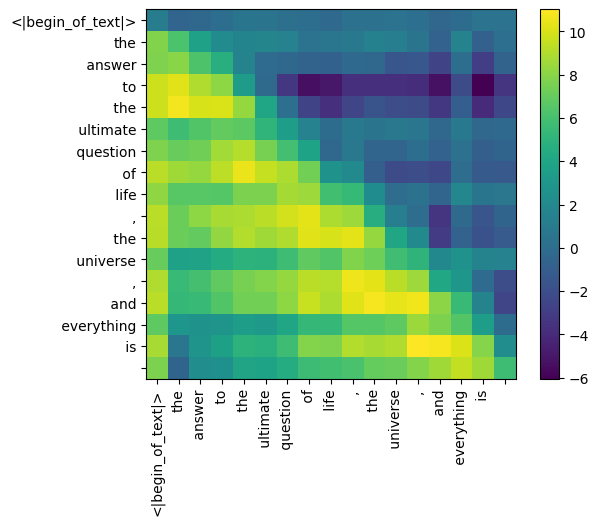

In [61]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(torch.float32).detach().cpu(), cmap='viridis')  # Convert to float32 and move to CPU
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens, rotation=90)  # Rotate for better readability if needed
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)

display_qk_heatmap(qk_per_token)

In [62]:
# applying the mask 
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

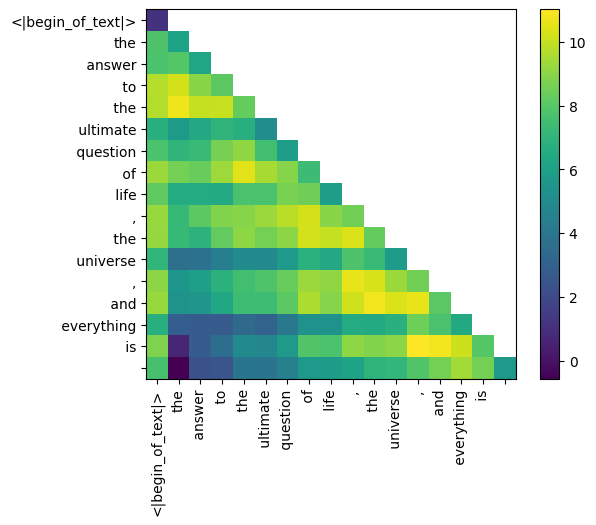

In [64]:
qk_per_token_after_masking = qk_per_token + mask.to(device)
display_qk_heatmap(qk_per_token_after_masking)

### applying the softmax function 


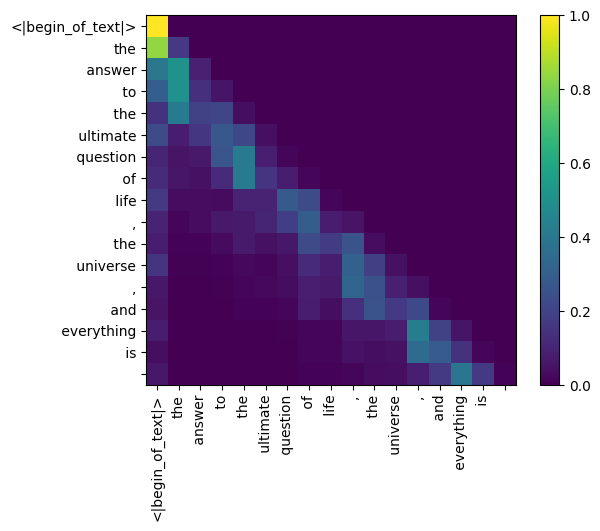

In [65]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

#### now doing the same with value vector (the distribution of dimensions is same as values(cause there are kv pairs))

note : the rope is not applied to the value matrices

In [68]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 64, 2048])

In [69]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([64, 2048])

In [70]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 64])

### doing the last matmul of self attention

In [71]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 64])

#### first layer and first head of attention is done so lets make a loop that will do the same for every head in all the layers


In [ ]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)].to(device))
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)].to(device))
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask.to(device)
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

print(len(qkv_attention_store))
print(qkv_attention_store[0].shape)
print(qkv_attention_store[0])

32
torch.Size([17, 64])
tensor([[ 0.0025,  0.0136, -0.0452,  ...,  0.0003, -0.0028,  0.1147],
        [-0.0161,  0.0388, -0.0244,  ...,  0.0027, -0.0105,  0.0635],
        [-0.0311,  0.0645,  0.0048,  ..., -0.0038, -0.0151,  0.0007],
        ...,
        [-0.0113,  0.0211, -0.0383,  ...,  0.0103, -0.0123,  0.0579],
        [-0.0068,  0.0168, -0.0403,  ...,  0.0098, -0.0192,  0.0549],
        [ 0.0018,  0.0082, -0.0208,  ...,  0.0099, -0.0123,  0.0383]],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<MmBackward0>)


In [81]:
### stacking them finally 
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 2048])

#### using the weight matrix to multiply with the ouptut

In [82]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([2048, 2048])

In [83]:
### it is a simple linear layer so just matmul 
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 2048])

In [ ]:
#we now have the change in the embedding value after attention, that should be adding to the original token embeddings
# basically the residual connection step
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 2048])

In [87]:
# normalizing 
# we are just following the flow which we say in the diagram earlier of the LLAMA model architecutre 
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 2048])

### loading the ff weights and implementing **swiGLU FFN** the feed forward network

In [88]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 2048])

In [89]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 2048])

***NOW WE ARE FINISHED FOR THE FIRST LAYER AND WE HAVE THE NEW EDITED EMBEDDING FOR EACH TOKEN AFTER FIRST LAYER AND WE JUST HAVE TO DO THIS FOR ANOTHER 32 LAYERS AND WE WILL DO THAT IN ONE LAST LOOP***

In [91]:
# WE HAVE ARRIVED AT THE FINALE 
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis.to(device))
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis.to(device))
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask.to(device)
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

In [93]:
print(final_embedding.shape)
print(len(final_embedding))
print(final_embedding[0])

torch.Size([17, 2048])
17
tensor([ 4.7812, -5.0625, 13.9375,  ..., -1.9219,  1.9062, -3.1562],
       device='mps:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)


In [94]:
# final normalization 
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 2048])

#### now lets decode 

In [95]:
model["output.weight"].shape

torch.Size([128256, 2048])

### use the embedding of the last token to predict the next value 


In [96]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [97]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983, device='mps:0')

In [101]:
tokenizer.decode([next_token.item()])

'42'

In [ ]:
# Initialize the tokenizer
# Using cl100k_base as an example - you may need to adjust based on your LLAMA model
enc = tiktoken.get_encoding("cl100k_base")

# Get token ID 42
token_id = 42

# Decode the token
decoded_token = enc.decode([token_id])
print(f"Token ID {token_id} decodes to: {decoded_token}")

# To see the raw bytes representation
raw_bytes = enc.decode_bytes([token_id])
print(f"Raw bytes: {raw_bytes}")

Token ID 42 decodes to: K
Raw bytes: b'K'


# WE ARE DONE LFGG